In [3]:
from sklearn.tree import DecisionTreeRegressor
from lib.decisiontree import fit_apply
import numpy

from lib.decisiontree_test import sample_X_y_w

# Performance:

sklearn implementation is O(n^2), as soon n is bigger than 10k it starts to be slow:

In [4]:
from time import perf_counter
import matplotlib.pyplot as plt

ns = numpy.logspace(2, 4.5, num=30)
dts = []
for n in ns:
    X, y, w, _ = sample_X_y_w(int(n))
    t = perf_counter()
    reg = DecisionTreeRegressor(max_depth=1, criterion='absolute_error')
    reg.fit(X, y, sample_weight=w).apply(X)
    dts.append(perf_counter() - t)


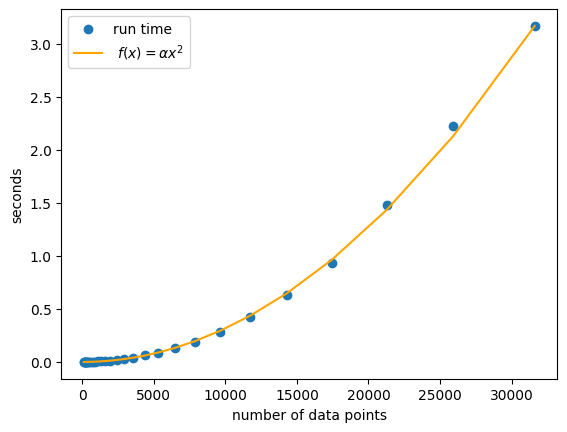

In [5]:
plt.scatter(ns, dts)
alpha = dts[-1] / ns[-1]**2
plt.plot(ns, alpha * ns**2, c='orange')
plt.legend(['run time', r" $f(x) = \alpha x^2$ "])
plt.xlabel('number of data points')
plt.ylabel('seconds');

In [6]:
%%time
X, y, w, _ = sample_X_y_w(50_000)

reg = DecisionTreeRegressor(max_depth=1, criterion='absolute_error')
reg.fit(X, y, sample_weight=w).apply(X)

CPU times: user 8.94 s, sys: 4.07 ms, total: 8.94 s
Wall time: 8.96 s


array([2, 2, 1, ..., 1, 1, 1], shape=(50000,))

My implementation is O(n log n), so it's much fast and can scale to millions of points (even a few billions if you are patient ^^). Though it's still much slower than the MSE based split from sklearn which is in O(n).

In [7]:
%%timeit
leaves = fit_apply(X, y, X_apply=X, sample_weights=w, algo='heaps')

26.8 ms ± 424 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%time
X, y, w, _ = sample_X_y_w(10**6)
leaves = fit_apply(X, y, X_apply=X, sample_weights=w, algo='heaps')

CPU times: user 823 ms, sys: 53 ms, total: 876 ms
Wall time: 874 ms


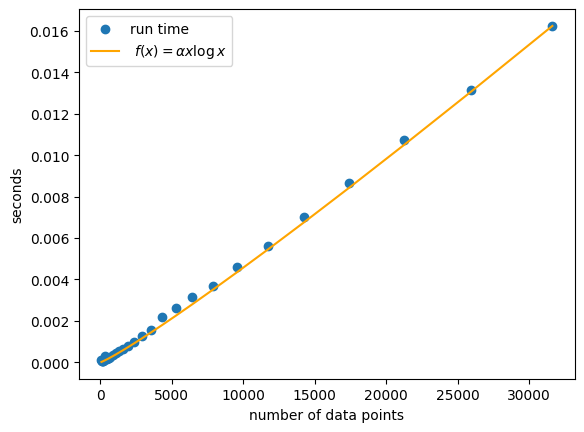

In [9]:
ns = numpy.logspace(2, 4.5, num=30)
dts = []
for n in ns:
    X, y, w, _ = sample_X_y_w(int(n))
    t = perf_counter()
    for _ in range(10):
        _ = fit_apply(X, y, X_apply=X, sample_weights=w, algo='heaps')
    dts.append((perf_counter() - t) / 10)

plt.scatter(ns, dts)
alpha = dts[-1] / ns[-1] / numpy.log(ns[-1])
plt.plot(ns, alpha * ns * numpy.log(ns), c='orange')
plt.legend(['run time', r" $f(x) = \alpha x \log x$ "])
plt.xlabel('number of data points')
plt.ylabel('seconds');

In [10]:
%%time
reg = DecisionTreeRegressor(max_depth=1, criterion='squared_error')
reg.fit(X, y, sample_weight=w).apply(X)

CPU times: user 7.79 ms, sys: 997 μs, total: 8.78 ms
Wall time: 7.67 ms


array([2, 1, 1, ..., 1, 2, 1], shape=(31622,))

# Correctness

As one can see by playing with the tests in `lib/decisiontree_test.py`, sklearn's implementation and mine amlost always give the same results. But sometimes mine gives lower absolute error, showing that sklearn's implementation isn't prefectly correct (when sample weights are given).

Note: I can't prove my implementation is prefectly correct (i.e. always returns the minimal-MAE split).

In [11]:
from lib.decisiontree_test import leaves_mae

X = numpy.array([
    [ 2.38, 3.13],
    [-0.87, 0.24],
    [ 3.42, 2.74],
    [ 1.43, 2.57],
    [ 0.86, 0.26]
])
y = numpy.array([0.784, 0.654, 1.125, 2.010, 0.614])
w = numpy.array([0.622, 1.356, 1.206, 0.912, 1.424])

In [14]:
import numpy as np

def abs_error_of_a_leaf(y, w):
    return min((np.abs(y - yi) * w).sum() for yi in y)

def abs_error_of_leaves(leaves, y, w):
    return sum(abs_error_of_a_leaf(y[leaves == i], w[leaves == i]) for i in np.unique(leaves))

X = np.array([
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4],
    [5, 5],
])
y = np.array([0.6, 0.6, 2.0, 0.7, 1.1])
w = np.array([3., 3., 2., 1., 2.])

In [21]:
X = np.array([[1], [2], [3], [4], [5]])
y = np.array([1, 1, 3, 1, 2])
w = np.array([3, 3, 2, 1, 2])

In [22]:
reg = DecisionTreeRegressor(max_depth=1, criterion='absolute_error')
sk_leaves = reg.fit(X, y, sample_weight=w).apply(X)
print("leaves:", sk_leaves, "total abs error:", abs_error_of_leaves(sk_leaves, y, w))

expected_leaves = np.array([1, 1, 2, 2, 2])
print("total abs error:", abs_error_of_leaves(expected_leaves, y, w))

leaves: [1 1 1 1 2] total abs error: 4
total abs error: 3


In [ ]:
reg.tree_.impurity, []

array([0.54545455, 0.44444444, 0.        ])

[4.  4.5 4. ]


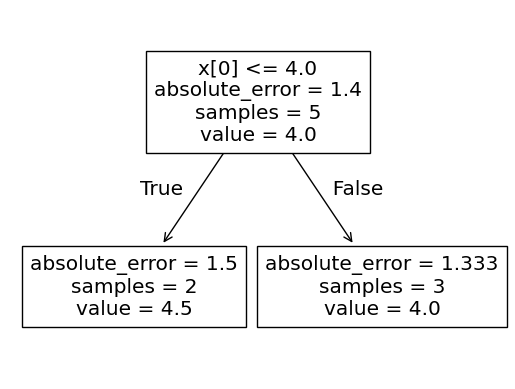

In [17]:
# Test MAE where all sample weights are uniform:
import numpy as np
dt_mae = DecisionTreeRegressor(
    random_state=0, criterion="absolute_error", max_leaf_nodes=2
)
dt_mae.fit(X=[[3], [5], [3], [8], [5]], y=[6, 7, 3, 4, 3], sample_weight=np.ones(5))
print(dt_mae.tree_.value.ravel())
from sklearn.tree import plot_tree
plot_tree(dt_mae);